In [132]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from sklearn.model_selection import train_test_split


In [133]:
const_lag15 =100
const_lag30 = 100
const_parade1 = 480
const_parade2 = 480
const_paradenight = 480
const_snow = 0

In [134]:
data = pd.read_csv("waiting_times_train.csv", sep=",")
meteo = pd.read_csv("weather_data.csv")
data = data.merge(meteo, on= "DATETIME", how = "left")
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

weather = pd.read_csv("weather_data.csv", sep=",")
weather['DATETIME'] = pd.to_datetime(weather['DATETIME'])

data['minute'] = data['DATETIME'].dt.hour*60 + data['DATETIME'].dt.minute

data['month'] = data['DATETIME'].dt.month
data['dayofweek'] = data['DATETIME'].dt.dayofweek
data['hour']=data['DATETIME'].dt.hour

data['is_weekend'] = data['dayofweek'].isin([5,6]).astype(int)

data['minute_sin'] = np.sin(2 * np.pi * data['minute'] / 1440)
data['minute_cos'] = np.cos(2 * np.pi * data['minute'] / 1440)

# Encodage cyclique pour jour de semaine (cycle 7 jours)
data['dayofweek_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dayofweek_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)

# Encodage cyclique pour mois (cycle 12 mois)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data = pd.get_dummies(data, columns=['ENTITY_DESCRIPTION_SHORT'])

data['is_peak_morning'] = (data['hour'].between(10, 12)).astype(int)
data['is_peak_afternoon'] = (data['hour'].between(14, 17)).astype(int)
data['is_closing_rush'] = (data['hour'] >= 19).astype(int)





val = pd.read_csv("waiting_times_X_test_val.csv", sep=",")
meteo = pd.read_csv("weather_data.csv")
val = val.merge(meteo, on= "DATETIME", how = "left")
val['DATETIME'] = pd.to_datetime(val['DATETIME'])

weather = pd.read_csv("weather_data.csv", sep=",")
weather['DATETIME'] = pd.to_datetime(weather['DATETIME'])

val['dayofweek'] = val['DATETIME'].dt.dayofweek

val['minute'] = val['DATETIME'].dt.hour*60 + val['DATETIME'].dt.minute
val['month'] = val['DATETIME'].dt.month
val['is_weekend'] = val['dayofweek'].isin([5,6]).astype(int)


val['minute_sin'] = np.sin(2 * np.pi * val['minute'] / 1440)
val['minute_cos'] = np.cos(2 * np.pi * val['minute'] / 1440)

# Encodage cyclique pour jour de semaine
val['dayofweek_sin'] = np.sin(2 * np.pi * val['dayofweek'] / 7)
val['dayofweek_cos'] = np.cos(2 * np.pi * val['dayofweek'] / 7)

# Encodage cyclique pour mois
val['month_sin'] = np.sin(2 * np.pi * val['month'] / 12)
val['month_cos'] = np.cos(2 * np.pi * val['month'] / 12)

# Conserver une copie de la colonne pour le CSV
val['hour']=val['DATETIME'].dt.hour
entity_desc = val["ENTITY_DESCRIPTION_SHORT"]
val['is_peak_morning'] = (val['hour'].between(10, 12)).astype(int)
val['is_peak_afternoon'] = (val['hour'].between(14, 17)).astype(int)
val['is_closing_rush'] = (val['hour'] >= 19).astype(int)



val = pd.get_dummies(val, columns=['ENTITY_DESCRIPTION_SHORT'])




In [135]:
for col in [c for c in data.columns if c.startswith('ENTITY_DESCRIPTION_SHORT_')]:
    mask = data[col]==1
    data.loc[mask, 'CURRENT_WAIT_TIME_lag_1'] = data.loc[mask, 'CURRENT_WAIT_TIME'].shift(1)
    data.loc[mask, 'CURRENT_WAIT_TIME_lag_2'] = data.loc[mask, 'CURRENT_WAIT_TIME'].shift(2)


lag_cols = [c for c in data.columns if 'lag' in c or 'roll' in c]

data['exists_minus_15'] = (~data['CURRENT_WAIT_TIME_lag_1'].isna()).astype(int)
data['exists_minus_30'] = (~data['CURRENT_WAIT_TIME_lag_2'].isna()).astype(int)



for col in [c for c in data.columns if c.startswith('ENTITY_DESCRIPTION_SHORT_')]:
    mask = val[col]==1
    val.loc[mask, 'CURRENT_WAIT_TIME_lag_1'] = val.loc[mask, 'CURRENT_WAIT_TIME'].shift(1)
    val.loc[mask, 'CURRENT_WAIT_TIME_lag_2'] = val.loc[mask, 'CURRENT_WAIT_TIME'].shift(2)


lag_cols = [c for c in val.columns if 'lag' in c or 'roll' in c]

val['exists_minus_15'] = (~val['CURRENT_WAIT_TIME_lag_1'].isna()).astype(int)
val['exists_minus_30'] = (~val['CURRENT_WAIT_TIME_lag_2'].isna()).astype(int)


In [136]:
cols_check = ['TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'snow']

for col in cols_check:
    if col in data.columns:  # on vérifie que la colonne existe
        data[f'{col}_isna'] = data[col].isna().astype(int)

cols_check = ['TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'snow']

for col in cols_check:
    if col in data.columns:  # on vérifie que la colonne existe
        val[f'{col}_isna'] = val[col].isna().astype(int)


In [137]:
# Ta liste de jours fériés
jours_feries = [
    "2018-01-01","2018-04-02","2018-05-01","2018-05-08","2018-05-10","2018-05-21","2018-07-14","2018-08-15","2018-11-01","2018-11-11","2018-12-25",
    "2019-01-01","2019-04-22","2019-05-01","2019-05-08","2019-05-30","2019-06-10","2019-07-14","2019-08-15","2019-11-01","2019-11-11","2019-12-25",
    "2020-01-01","2020-04-13","2020-05-01","2020-05-08","2020-05-21","2020-06-01","2020-07-14","2020-08-15","2020-11-01","2020-11-11","2020-12-25",
    "2021-01-01","2021-04-05","2021-05-01","2021-05-08","2021-05-13","2021-05-24","2021-07-14","2021-08-15","2021-11-01","2021-11-11","2021-12-25",
    "2022-01-01","2022-04-18","2022-05-01","2022-05-08","2022-05-26","2022-06-06","2022-07-14","2022-08-15","2022-11-01","2022-11-11","2022-12-25"
]

# Convertir en datetime.date
jours_feries = pd.to_datetime(jours_feries).date

# Créer la colonne is_holiday
data['is_férié'] = data['DATETIME'].dt.date.isin(jours_feries).astype(int)

val['is_férié'] = val['DATETIME'].dt.date.isin(jours_feries).astype(int)



In [ ]:
vacances_scolaires_2017_2023 = [
    "2017-12-23","2017-12-24","2017-12-25","2017-12-26","2017-12-27","2017-12-28","2017-12-29","2017-12-30","2017-12-31",
    "2018-01-01","2018-01-02","2018-01-03","2018-01-04","2018-01-05","2018-01-06","2018-01-07",
    "2018-02-10","2018-02-11","2018-02-12","2018-02-13","2018-02-14","2018-02-15","2018-02-16","2018-02-17","2018-02-18","2018-02-19",
    "2018-02-20","2018-02-21","2018-02-22","2018-02-23","2018-02-24","2018-02-25","2018-02-26","2018-02-27","2018-02-28","2018-03-01",
    "2018-03-02","2018-03-03","2018-03-04","2018-03-05","2018-03-06","2018-03-07","2018-03-08","2018-03-09","2018-03-10","2018-03-11",
    "2018-04-07","2018-04-08","2018-04-09","2018-04-10","2018-04-11","2018-04-12","2018-04-13","2018-04-14","2018-04-15","2018-04-16",
    "2018-04-17","2018-04-18","2018-04-19","2018-04-20","2018-04-21","2018-04-22","2018-04-23","2018-04-24","2018-04-25","2018-04-26",
    "2018-04-27","2018-04-28","2018-04-29","2018-04-30",
    "2018-07-07","2018-07-08","2018-07-09","2018-07-10","2018-07-11","2018-07-12","2018-07-13","2018-07-14","2018-07-15","2018-07-16",
    "2018-07-17","2018-07-18","2018-07-19","2018-07-20","2018-07-21","2018-07-22","2018-07-23","2018-07-24","2018-07-25","2018-07-26",
    "2018-07-27","2018-07-28","2018-07-29","2018-07-30","2018-07-31","2018-08-01","2018-08-02","2018-08-03","2018-08-04","2018-08-05",
    "2018-08-06","2018-08-07","2018-08-08","2018-08-09","2018-08-10","2018-08-11","2018-08-12","2018-08-13","2018-08-14","2018-08-15",
    "2018-08-16","2018-08-17","2018-08-18","2018-08-19","2018-08-20","2018-08-21","2018-08-22","2018-08-23","2018-08-24","2018-08-25",
    "2018-08-26","2018-08-27","2018-08-28","2018-08-29","2018-08-30","2018-08-31","2018-09-01","2018-09-02",
    "2018-10-20","2018-10-21","2018-10-22","2018-10-23","2018-10-24","2018-10-25","2018-10-26","2018-10-27","2018-10-28","2018-10-29",
    "2018-10-30","2018-10-31","2018-11-01","2018-11-02","2018-11-03","2018-11-04","2018-11-05","2018-12-22","2018-12-23","2018-12-24","2018-12-25","2018-12-26","2018-12-27","2018-12-28","2018-12-29","2018-12-30","2018-12-31","2019-01-01","2019-01-02","2019-01-03","2019-01-04","2019-01-05","2019-01-06","2019-01-07","2019-02-09","2019-02-10","2019-02-11","2019-02-12","2019-02-13","2019-02-14","2019-02-15","2019-02-16","2019-02-17","2019-02-18",
    "2019-02-19","2019-02-20","2019-02-21","2019-02-22","2019-02-23","2019-02-24","2019-02-25","2019-02-26","2019-02-27","2019-02-28",
    "2019-03-01","2019-03-02","2019-03-03","2019-03-04","2019-03-05","2019-03-06","2019-03-07","2019-03-08","2019-03-09","2019-03-10",
    "2019-03-11",
    "2019-04-06","2019-04-07","2019-04-08","2019-04-09","2019-04-10","2019-04-11","2019-04-12","2019-04-13","2019-04-14","2019-04-15",
    "2019-04-16","2019-04-17","2019-04-18","2019-04-19","2019-04-20","2019-04-21","2019-04-22","2019-04-23","2019-04-24","2019-04-25",
    "2019-04-26","2019-04-27","2019-04-28","2019-04-29","2019-04-30","2019-05-01","2019-05-02","2019-05-03","2019-05-04","2019-05-05",
    "2019-05-06","2019-07-06","2019-07-07","2019-07-08","2019-07-09","2019-07-10","2019-07-11","2019-07-12","2019-07-13","2019-07-14","2019-07-15",
    "2019-07-16","2019-07-17","2019-07-18","2019-07-19","2019-07-20","2019-07-21","2019-07-22","2019-07-23","2019-07-24","2019-07-25",
    "2019-07-26","2019-07-27","2019-07-28","2019-07-29","2019-07-30","2019-07-31","2019-08-01","2019-08-02","2019-08-03","2019-08-04",
    "2019-08-05","2019-08-06","2019-08-07","2019-08-08","2019-08-09","2019-08-10","2019-08-11","2019-08-12","2019-08-13","2019-08-14",
    "2019-08-15","2019-08-16","2019-08-17","2019-08-18","2019-08-19","2019-08-20","2019-08-21","2019-08-22","2019-08-23","2019-08-24",
    "2019-08-25","2019-08-26","2019-08-27","2019-08-28","2019-08-29","2019-08-30","2019-08-31","2019-09-01","2019-09-02",
    "2019-10-19","2019-10-20","2019-10-21","2019-10-22","2019-10-23","2019-10-24","2019-10-25","2019-10-26","2019-10-27","2019-10-28",
    "2019-10-29","2019-10-30","2019-10-31","2019-11-01","2019-11-02","2019-11-03","2019-11-04",
    "2019-12-21","2019-12-22","2019-12-23","2019-12-24","2019-12-25","2019-12-26","2019-12-27","2019-12-28","2019-12-29","2019-12-30",
    "2019-12-31","2020-01-01","2020-01-02","2020-01-03","2020-01-04","2020-01-05","2020-01-06",
    "2020-02-08","2020-02-09","2020-02-10","2020-02-11","2020-02-12","2020-02-13","2020-02-14","2020-02-15","2020-02-16","2020-02-17",
    "2020-02-18","2020-02-19","2020-02-20","2020-02-21","2020-02-22","2020-02-23","2020-02-24","2020-02-25","2020-02-26","2020-02-27",
    "2020-02-28","2020-02-29","2020-03-01","2020-03-02","2020-03-03","2020-03-04","2020-03-05","2020-03-06","2020-03-07","2020-03-08",
    "2020-03-09",
    "2020-04-04","2020-04-05","2020-04-06","2020-04-07","2020-04-08","2020-04-09","2020-04-10","2020-04-11","2020-04-12","2020-04-13",
    "2020-04-14","2020-04-15","2020-04-16","2020-04-17","2020-04-18","2020-04-19","2020-04-20","2020-04-21","2020-04-22","2020-04-23",
    "2020-04-24","2020-04-25","2020-04-26","2020-04-27","2020-04-28","2020-04-29","2020-04-30","2020-05-01","2020-05-02","2020-05-03",
    "2020-05-04",
    "2020-07-04","2020-07-05","2020-07-06","2020-07-07","2020-07-08","2020-07-09","2020-07-10","2020-07-11","2020-07-12","2020-07-13",
    "2020-07-14","2020-07-15","2020-07-16","2020-07-17","2020-07-18","2020-07-19","2020-07-20","2020-07-21","2020-07-22","2020-07-23",
    "2020-07-24","2020-07-25","2020-07-26","2020-07-27","2020-07-28","2020-07-29","2020-07-30","2020-07-31","2020-08-01","2020-08-02",
    "2020-08-03","2020-08-04","2020-08-05","2020-08-06","2020-08-07","2020-08-08","2020-08-09","2020-08-10","2020-08-11","2020-08-12",
    "2020-08-13","2020-08-14","2020-08-15","2020-08-16","2020-08-17","2020-08-18","2020-08-19","2020-08-20","2020-08-21","2020-08-22",
    "2020-08-23","2020-08-24","2020-08-25","2020-08-26","2020-08-27","2020-08-28","2020-08-29","2020-08-30","2020-08-31","2020-09-01",
    "2020-09-02",
    "2020-10-17","2020-10-18","2020-10-19","2020-10-20","2020-10-21","2020-10-22","2020-10-23","2020-10-24","2020-10-25","2020-10-26",
    "2020-10-27","2020-10-28","2020-10-29","2020-10-30","2020-10-31","2020-11-01","2020-11-02",
    "2020-12-19","2020-12-20","2020-12-21","2020-12-22","2020-12-23","2020-12-24","2020-12-25","2020-12-26","2020-12-27","2020-12-28",
    "2020-12-29","2020-12-30","2020-12-31","2021-01-01","2021-01-02","2021-01-03","2021-01-04",
    "2021-02-06","2021-02-07","2021-02-08","2021-02-09","2021-02-10","2021-02-11","2021-02-12","2021-02-13","2021-02-14","2021-02-15",
    "2021-02-16","2021-02-17","2021-02-18","2021-02-19","2021-02-20","2021-02-21","2021-02-22","2021-02-23","2021-02-24","2021-02-25",
    "2021-02-26","2021-02-27","2021-02-28","2021-03-01",
    "2021-04-10","2021-04-11","2021-04-12","2021-04-13","2021-04-14","2021-04-15","2021-04-16","2021-04-17","2021-04-18","2021-04-19",
    "2021-04-20","2021-04-21","2021-04-22","2021-04-23","2021-04-24","2021-04-25","2021-04-26","2021-04-27","2021-04-28","2021-04-29",
    "2021-04-30","2021-05-01","2021-05-02","2021-05-03",
    "2021-07-07","2021-07-08","2021-07-09","2021-07-10","2021-07-11","2021-07-12","2021-07-13","2021-07-14","2021-07-15","2021-07-16",
    "2021-07-17","2021-07-18","2021-07-19","2021-07-20","2021-07-21","2021-07-22","2021-07-23","2021-07-24","2021-07-25","2021-07-26",
    "2021-07-27","2021-07-28","2021-07-29","2021-07-30","2021-07-31","2021-08-01","2021-08-02","2021-08-03","2021-08-04","2021-08-05",
    "2021-08-06","2021-08-07","2021-08-08","2021-08-09","2021-08-10","2021-08-11","2021-08-12","2021-08-13","2021-08-14","2021-08-15",
    "2021-08-16","2021-08-17","2021-08-18","2021-08-19","2021-08-20","2021-08-21","2021-08-22","2021-08-23","2021-08-24","2021-08-25",
    "2021-08-26","2021-08-27","2021-08-28","2021-08-29","2021-08-30","2021-08-31","2021-09-01","2021-09-02",
    "2021-10-23","2021-10-24","2021-10-25","2021-10-26","2021-10-27","2021-10-28","2021-10-29","2021-10-30","2021-10-31","2021-11-01",
    "2021-11-02","2021-11-03","2021-11-04","2021-11-05","2021-11-06","2021-11-07","2021-11-08",
    "2021-12-18","2021-12-19","2021-12-20","2021-12-21","2021-12-22","2021-12-23","2021-12-24","2021-12-25","2021-12-26","2021-12-27",
    "2021-12-28","2021-12-29","2021-12-30","2021-12-31","2022-01-01","2022-01-02","2022-01-03",
    "2022-02-05","2022-02-06","2022-02-07","2022-02-08","2022-02-09","2022-02-10","2022-02-11","2022-02-12","2022-02-13","2022-02-14",
    "2022-02-15","2022-02-16","2022-02-17","2022-02-18","2022-02-19","2022-02-20","2022-02-21","2022-02-22","2022-02-23","2022-02-24",
    "2022-02-25","2022-02-26","2022-02-27","2022-02-28","2022-03-01","2022-03-02","2022-03-03","2022-03-04","2022-03-05","2022-03-06","2022-03-07",
    "2022-04-09","2022-04-10","2022-04-11","2022-04-12","2022-04-13","2022-04-14","2022-04-15","2022-04-16","2022-04-17","2022-04-18",
    "2022-04-19","2022-04-20","2022-04-21","2022-04-22","2022-04-23","2022-04-24","2022-04-25","2022-04-26","2022-04-27","2022-04-28",
    "2022-04-29","2022-04-30","2022-05-01","2022-05-02","2022-05-03","2022-05-04","2022-05-05","2022-05-06","2022-05-07","2022-05-08","2022-05-09",
    "2022-07-07","2022-07-08","2022-07-09","2022-07-10","2022-07-11","2022-07-12","2022-07-13","2022-07-14","2022-07-15","2022-07-16",
    "2022-07-17","2022-07-18","2022-07-19","2022-07-20","2022-07-21","2022-07-22","2022-07-23","2022-07-24","2022-07-25","2022-07-26",
    "2022-07-27","2022-07-28","2022-07-29","2022-07-30","2022-07-31","2022-08-01","2022-08-02","2022-08-03","2022-08-04","2022-08-05",
    "2022-08-06","2022-08-07","2022-08-08","2022-08-09","2022-08-10","2022-08-11","2022-08-12","2022-08-13","2022-08-14","2022-08-15",
    "2022-08-16","2022-08-17","2022-08-18","2022-08-19","2022-08-20","2022-08-21","2022-08-22","2022-08-23","2022-08-24","2022-08-25",
    "2022-08-26","2022-08-27","2022-08-28","2022-08-29","2022-08-30","2022-08-31","2022-09-01","2022-09-02",
    "2022-10-22","2022-10-23","2022-10-24","2022-10-25","2022-10-26","2022-10-27","2022-10-28","2022-10-29","2022-10-30","2022-10-31",
    "2022-11-01","2022-11-02","2022-11-03","2022-11-04","2022-11-05","2022-11-06","2022-11-07",
    "2022-12-17","2022-12-18","2022-12-19","2022-12-20","2022-12-21","2022-12-22","2022-12-23","2022-12-24","2022-12-25","2022-12-26",
    "2022-12-27","2022-12-28","2022-12-29","2022-12-30","2022-12-31","2023-01-01","2023-01-02","2023-01-03",
    "2023-02-04","2023-02-05","2023-02-06","2023-02-07","2023-02-08","2023-02-09","2023-02-10","2023-02-11","2023-02-12","2023-02-13",
    "2023-02-14","2023-02-15","2023-02-16","2023-02-17","2023-02-18","2023-02-19","2023-02-20","2023-02-21","2023-02-22","2023-02-23",
    "2023-02-24","2023-02-25","2023-02-26","2023-02-27","2023-02-28","2023-03-01","2023-03-02","2023-03-03","2023-03-04","2023-03-05","2023-03-06",
    "2023-04-08","2023-04-09","2023-04-10","2023-04-11","2023-04-12","2023-04-13","2023-04-14","2023-04-15","2023-04-16","2023-04-17",
    "2023-04-18","2023-04-19","2023-04-20","2023-04-21","2023-04-22","2023-04-23","2023-04-24","2023-04-25","2023-04-26","2023-04-27",
    "2023-04-28","2023-04-29","2023-04-30","2023-05-01","2023-05-02","2023-05-03","2023-05-04","2023-05-05","2023-05-06","2023-05-07",
    "2023-05-08","2023-05-09",
    "2023-07-08","2023-07-09","2023-07-10","2023-07-11","2023-07-12","2023-07-13","2023-07-14","2023-07-15","2023-07-16","2023-07-17",
    "2023-07-18","2023-07-19","2023-07-20","2023-07-21","2023-07-22","2023-07-23","2023-07-24","2023-07-25","2023-07-26","2023-07-27",
    "2023-07-28","2023-07-29","2023-07-30","2023-07-31","2023-08-01","2023-08-02","2023-08-03","2023-08-04","2023-08-05","2023-08-06",
    "2023-08-07","2023-08-08","2023-08-09","2023-08-10","2023-08-11","2023-08-12","2023-08-13","2023-08-14","2023-08-15","2023-08-16",
    "2023-08-17","2023-08-18","2023-08-19","2023-08-20","2023-08-21","2023-08-22","2023-08-23","2023-08-24","2023-08-25","2023-08-26",
    "2023-08-27","2023-08-28","2023-08-29","2023-08-30","2023-08-31"

]

vacances_scolaires_2017_2023_dt = pd.to_datetime(vacances_scolaires_2017_2023)

data["vacances"] = data["DATETIME"].dt.date.isin(vacances_scolaires_2017_2023_dt)

val["vacances"] = val["DATETIME"].dt.date.isin(vacances_scolaires_2017_2023_dt)


In [139]:
fillna_mapping = {
    'CURRENT_WAIT_TIME_lag_1': const_lag15,
    'CURRENT_WAIT_TIME_lag_2': const_lag30,
    'TIME_TO_PARADE_1': const_parade1,
    'TIME_TO_PARADE_2': const_parade2,
    'TIME_TO_NIGHT_SHOW': const_paradenight,
    'snow_1h': const_snow,

}

for col in fillna_mapping:
    data[col] = data[col].fillna(fillna_mapping[col])
    val[col] = val[col].fillna(fillna_mapping[col])
    


In [180]:


data.to_csv("train_vac.csv", index=False)
data.to_csv("val_vac.csv", index = False)

data = data[ data["WAIT_TIME_IN_2H"] <=75]
data.columns.tolist()

['DATETIME',
 'ADJUST_CAPACITY',
 'DOWNTIME',
 'CURRENT_WAIT_TIME',
 'TIME_TO_PARADE_1',
 'TIME_TO_PARADE_2',
 'TIME_TO_NIGHT_SHOW',
 'WAIT_TIME_IN_2H',
 'temp',
 'dew_point',
 'feels_like',
 'pressure',
 'humidity',
 'wind_speed',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'minute',
 'month',
 'dayofweek',
 'hour',
 'is_weekend',
 'minute_sin',
 'minute_cos',
 'dayofweek_sin',
 'dayofweek_cos',
 'month_sin',
 'month_cos',
 'ENTITY_DESCRIPTION_SHORT_Flying Coaster',
 'ENTITY_DESCRIPTION_SHORT_Pirate Ship',
 'ENTITY_DESCRIPTION_SHORT_Water Ride',
 'is_peak_morning',
 'is_peak_afternoon',
 'is_closing_rush',
 'CURRENT_WAIT_TIME_lag_1',
 'CURRENT_WAIT_TIME_lag_2',
 'exists_minus_15',
 'exists_minus_30',
 'TIME_TO_PARADE_1_isna',
 'TIME_TO_PARADE_2_isna',
 'TIME_TO_NIGHT_SHOW_isna',
 'is_férié',
 'vacances']

In [129]:


X = data.drop(columns=['WAIT_TIME_IN_2H',"DATETIME","dayofweek","month","minute"])
y = data['WAIT_TIME_IN_2H']


xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators':[500],
    'max_depth':[9],
    'learning_rate':[0.05],
    'subsample':[0.8,1.0]
}

grid_search = GridSearchCV(xgb_model,param_grid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1, verbose = 2)
grid_search.fit(X,y)
print("Meilleurs paramètres XGBoost :", grid_search.best_params_)



xgb_final_full = xgb.XGBRegressor(**grid_search.best_params_, objective='reg:squarederror', random_state=42)
xgb_final_full.fit(X, y)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


KeyboardInterrupt: 

In [173]:
X = data.drop(columns=['WAIT_TIME_IN_2H',"DATETIME","dayofweek","month","minute","dew_point","pressure","humidity",'hour',"wind_speed",])
y = data['WAIT_TIME_IN_2H']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.15,
    random_state=42
)

print(f"📊 Train: {len(X_train)} samples")
print(f"📊 Validation: {len(X_val)} samples")

# Vos paramètres (identiques)
param_grid = {
    'n_estimators': 300,  # Plus d'arbres mais early stopping va optimiser
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42,
    "early_stopping_rounds" : 20
}
param_grid['eval_metric'] = 'rmse'
xgb_final = xgb.XGBRegressor(**param_grid)

print("🚀 Entraînement avec early stopping...")

xgb_final.fit(
    X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)  ],
    
    verbose=50          
)


train_pred = xgb_final.predict(X_train)
val_pred = xgb_final.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"\n✅ RÉSULTATS FINAUX :")
print(f"🎯 RMSE Train: {train_rmse:.4f}")
print(f"🎯 RMSE Validation: {val_rmse:.4f}")

# Vérification overfitting
overfitting_gap = val_rmse - train_rmse
if overfitting_gap > 2.0:
    print(f"⚠️  Overfitting détecté ! Gap: {overfitting_gap:.4f}")
    print("   → Essayez learning_rate plus faible ou max_depth plus petit")
elif overfitting_gap < 0.5:
    print(f"✅ Modèle bien équilibré ! Gap: {overfitting_gap:.4f}")
else:
    print(f"📊 Gap acceptable: {overfitting_gap:.4f}")

print(f"🏁 Entraînement arrêté à l'itération: {xgb_final.best_iteration}")
print(f"📈 Nombre d'arbres optimaux: {xgb_final.best_iteration + 1}")


📊 Train: 31403 samples
📊 Validation: 5542 samples
🚀 Entraînement avec early stopping...
[0]	validation_0-rmse:13.40634	validation_1-rmse:13.37378
[50]	validation_0-rmse:8.67583	validation_1-rmse:8.79612
[100]	validation_0-rmse:8.18412	validation_1-rmse:8.39078
[150]	validation_0-rmse:7.86481	validation_1-rmse:8.14662
[200]	validation_0-rmse:7.62847	validation_1-rmse:7.96816
[250]	validation_0-rmse:7.44726	validation_1-rmse:7.84501
[299]	validation_0-rmse:7.27059	validation_1-rmse:7.72512

✅ RÉSULTATS FINAUX :
🎯 RMSE Train: 7.2706
🎯 RMSE Validation: 7.7251
✅ Modèle bien équilibré ! Gap: 0.4545
🏁 Entraînement arrêté à l'itération: 299
📈 Nombre d'arbres optimaux: 300


In [ ]:
#nouvel entrainement avec la regularisation :

X = data.drop(columns=['WAIT_TIME_IN_2H',"DATETIME","dayofweek","month","minute",'hour',"dew_point","pressure","humidity"])
y = data['WAIT_TIME_IN_2H']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.15,
    random_state=42
)

print(f"📊 Train: {len(X_train)} samples")
print(f"📊 Validation: {len(X_val)} samples")

# Vos paramètres (identiques)
param_grid = {
    'n_estimators': 1000,  # Plus d'arbres mais early stopping va optimiser
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42,
    "early_stopping_rounds" : 20,
    'reg_alpha': 5,          # L1 régularisation (sélection features)
    'reg_lambda': 5,         # L2 régularisation (stabilisation)
    'colsample_bytree': 0.8, # Échantillonnage features (anti-overfitting)
    'min_child_weight': 3    # Poids minimum par feuille (anti-overfitting)
}
param_grid['eval_metric'] = 'rmse'
xgb_final = xgb.XGBRegressor(**param_grid)

print("🚀 Entraînement avec early stopping...")

xgb_final.fit(
    X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)  ],
    
    verbose=50          
)


train_pred = xgb_final.predict(X_train)
val_pred = xgb_final.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"\n✅ RÉSULTATS FINAUX :")
print(f"🎯 RMSE Train: {train_rmse:.4f}")
print(f"🎯 RMSE Validation: {val_rmse:.4f}")

# Vérification overfitting
overfitting_gap = val_rmse - train_rmse
if overfitting_gap > 2.0:
    print(f"⚠️  Overfitting détecté ! Gap: {overfitting_gap:.4f}")
    print("   → Essayez learning_rate plus faible ou max_depth plus petit")
elif overfitting_gap < 0.5:
    print(f"✅ Modèle bien équilibré ! Gap: {overfitting_gap:.4f}")
else:
    print(f"📊 Gap acceptable: {overfitting_gap:.4f}")

print(f"🏁 Entraînement arrêté à l'itération: {xgb_final.best_iteration}")
print(f"📈 Nombre d'arbres optimaux: {xgb_final.best_iteration + 1}")


📊 Train: 31403 samples
📊 Validation: 5542 samples
🚀 Entraînement avec early stopping...
[0]	validation_0-rmse:13.75863	validation_1-rmse:13.71692
[50]	validation_0-rmse:9.70328	validation_1-rmse:9.71198
[100]	validation_0-rmse:9.18763	validation_1-rmse:9.22777
[150]	validation_0-rmse:8.93940	validation_1-rmse:9.00039
[200]	validation_0-rmse:8.76771	validation_1-rmse:8.85312
[250]	validation_0-rmse:8.63142	validation_1-rmse:8.73434
[300]	validation_0-rmse:8.53016	validation_1-rmse:8.65959
[350]	validation_0-rmse:8.43971	validation_1-rmse:8.58235
[400]	validation_0-rmse:8.35768	validation_1-rmse:8.51510
[450]	validation_0-rmse:8.27737	validation_1-rmse:8.45377
[500]	validation_0-rmse:8.20705	validation_1-rmse:8.39676
[550]	validation_0-rmse:8.14866	validation_1-rmse:8.35427
[600]	validation_0-rmse:8.08756	validation_1-rmse:8.30767
[650]	validation_0-rmse:8.03469	validation_1-rmse:8.26469
[700]	validation_0-rmse:7.98829	validation_1-rmse:8.23434
[750]	validation_0-rmse:7.93522	validation_

In [161]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Vos données (identiques)
X = data.drop(columns=['WAIT_TIME_IN_2H',"DATETIME","dayofweek","month","minute","dew_point","pressure","humidity",'hour'])
y = data['WAIT_TIME_IN_2H']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

print("🔬 RECHERCHE DES VALEURS OPTIMALES DE RÉGULARISATION")
print("=" * 60)

# ===== TEST SYSTÉMATIQUE DES VALEURS =====
configs_to_test = [
    # Format: (reg_alpha, reg_lambda, description)
    (0, 1, "Baseline (défaut XGBoost)"),
    (0, 5, "Lambda seul (modéré)"),
    (0, 10, "Lambda seul (fort)"),
    (5, 1, "Alpha seul (modéré)"),
    (10, 1, "Alpha seul (fort)"),
    (2, 2, "Équilibré léger"),
    (5, 5, "Ma recommandation"),
    (3, 8, "L2 dominant"),
    (8, 3, "L1 dominant"),
    (10, 10, "Régularisation forte"),
    (1, 15, "L2 très fort"),
    (15, 1, "L1 très fort")
]

results = []

for i, (alpha, lambda_val, desc) in enumerate(configs_to_test):
    print(f"\n🧪 Test {i+1}/{len(configs_to_test)}: {desc}")
    print(f"   reg_alpha={alpha}, reg_lambda={lambda_val}")
    
    # Configuration du modèle
    params = {
        'n_estimators': 1000,
        'max_depth': 5,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'objective': 'reg:squarederror',
        'random_state': 42,
        'early_stopping_rounds': 30,
        'eval_metric': 'rmse',
        'reg_alpha': alpha,
        'reg_lambda': lambda_val,
        'colsample_bytree': 0.8,
        'min_child_weight': 3
    }
    
    # Entraînement
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=200 
    )
    
    # Évaluation
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    gap = val_rmse - train_rmse
    
    results.append({
        'config': f"α={alpha}, λ={lambda_val}",
        'description': desc,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'gap': gap,
        'reg_alpha': alpha,
        'reg_lambda': lambda_val,
        'best_iteration': getattr(model, 'best_iteration', params['n_estimators'])
    })
    
    print(f"   ✅ Train: {train_rmse:.4f}, Val: {val_rmse:.4f}, Gap: {gap:.4f}")

# ===== ANALYSE DES RÉSULTATS =====
print("\n" + "=" * 60)
print("📊 RÉSULTATS COMPLETS (triés par RMSE validation)")
print("=" * 60)

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values('val_rmse')

for i, row in results_df_sorted.iterrows():
    rank = list(results_df_sorted.index).index(i) + 1
    star = "🏆" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    
    print(f"{star} #{rank:2d} | {row['config']:12s} | Val: {row['val_rmse']:6.4f} | Gap: {row['gap']:6.4f} | {row['description']}")

# ===== RECOMMANDATIONS FINALES =====
best_config = results_df_sorted.iloc[0]
second_best = results_df_sorted.iloc[1]

print("\n" + "🏆" * 20)
print("RECOMMANDATIONS FINALES")
print("🏆" * 20)

print(f"\n✅ MEILLEUR MODÈLE:")
print(f"   Configuration: reg_alpha={best_config['reg_alpha']}, reg_lambda={best_config['reg_lambda']}")
print(f"   RMSE Validation: {best_config['val_rmse']:.4f}")
print(f"   Gap Train/Val: {best_config['gap']:.4f}")
print(f"   Description: {best_config['description']}")

print(f"\n🥈 SECOND CHOIX:")
print(f"   Configuration: reg_alpha={second_best['reg_alpha']}, reg_lambda={second_best['reg_lambda']}")  
print(f"   RMSE Validation: {second_best['val_rmse']:.4f}")
print(f"   Différence avec le meilleur: +{second_best['val_rmse'] - best_config['val_rmse']:.4f}")

# ===== COMPARAISON AVEC MES RECOMMANDATIONS =====
my_recommendation = results_df[
    (results_df['reg_alpha'] == 5) & (results_df['reg_lambda'] == 5)
].iloc[0]

my_rank = list(results_df_sorted[
    (results_df_sorted['reg_alpha'] == 5) & (results_df_sorted['reg_lambda'] == 5)
].index)[0]
my_rank_position = list(results_df_sorted.index).index(my_rank) + 1

print(f"\n🤖 MES RECOMMANDATIONS INITIALES:")
print(f"   Configuration: reg_alpha=5, reg_lambda=5")
print(f"   RMSE Validation: {my_recommendation['val_rmse']:.4f}")
print(f"   Classement: #{my_rank_position}/{len(configs_to_test)}")
print(f"   Écart avec optimal: +{my_recommendation['val_rmse'] - best_config['val_rmse']:.4f}")

if my_rank_position <= 3:
    print("   🎯 Mes recommandations étaient dans le TOP 3 ! ✅")
elif my_rank_position <= len(configs_to_test) // 2:
    print("   📊 Mes recommandations étaient correctes mais pas optimales")
else:
    print("   ❌ Mes recommandations étaient sous-optimales")

# ===== CODE FINAL OPTIMISÉ =====
print(f"\n💻 CODE FINAL AVEC PARAMÈTRES OPTIMAUX:")
print("-" * 50)
print("# Remplacez votre param_grid par :")
print("param_grid_optimal = {")
print("    'n_estimators': 300,")
print("    'max_depth': 4,")
print("    'learning_rate': 0.1,")
print("    'subsample': 0.8,")
print("    'objective': 'reg:squarederror',")
print("    'random_state': 42,")
print("    'early_stopping_rounds': 20,")
print("    'eval_metric': 'rmse',")
print(f"    'reg_alpha': {best_config['reg_alpha']},")
print(f"    'reg_lambda': {best_config['reg_lambda']},")
print("    'colsample_bytree': 0.8,")
print("    'min_child_weight': 3")
print("}")

print(f"\n🎯 AMÉLIORATION ATTENDUE:")
if 'val_rmse' in locals() and hasattr(locals(), 'baseline_rmse'):
    baseline_rmse = 8.01  # Votre performance actuelle estimée
else:
    baseline_rmse = results_df[
        (results_df['reg_alpha'] == 0) & (results_df['reg_lambda'] == 1)
    ]['val_rmse'].iloc[0]

improvement = baseline_rmse - best_config['val_rmse']
improvement_pct = (improvement / baseline_rmse) * 100

print(f"   Baseline estimé: {baseline_rmse:.4f}")
print(f"   Optimal trouvé: {best_config['val_rmse']:.4f}")
print(f"   Amélioration: -{improvement:.4f} ({improvement_pct:.1f}%)")

🔬 RECHERCHE DES VALEURS OPTIMALES DE RÉGULARISATION

🧪 Test 1/12: Baseline (défaut XGBoost)
   reg_alpha=0, reg_lambda=1
[0]	validation_0-rmse:13.68680	validation_1-rmse:13.65297
[200]	validation_0-rmse:7.61488	validation_1-rmse:7.96122
[400]	validation_0-rmse:6.89318	validation_1-rmse:7.48200
[600]	validation_0-rmse:6.42370	validation_1-rmse:7.22288
[800]	validation_0-rmse:6.05862	validation_1-rmse:7.05212
[999]	validation_0-rmse:5.75694	validation_1-rmse:6.92259
   ✅ Train: 5.7569, Val: 6.9226, Gap: 1.1656

🧪 Test 2/12: Lambda seul (modéré)
   reg_alpha=0, reg_lambda=5
[0]	validation_0-rmse:13.68943	validation_1-rmse:13.65472
[200]	validation_0-rmse:7.68102	validation_1-rmse:8.00316
[400]	validation_0-rmse:6.97155	validation_1-rmse:7.52573
[600]	validation_0-rmse:6.52482	validation_1-rmse:7.27956
[800]	validation_0-rmse:6.17021	validation_1-rmse:7.10008
[999]	validation_0-rmse:5.87408	validation_1-rmse:6.95940
   ✅ Train: 5.8741, Val: 6.9594, Gap: 1.0853

🧪 Test 3/12: Lambda seul (fo

In [179]:


# Préparer X_test_val pour la prédiction
X_test_val = val[X.columns]

y_val_pred = xgb_final.predict(X_test_val)


submission = pd.DataFrame({
    'DATETIME': val['DATETIME'],
    'ENTITY_DESCRIPTION_SHORT': entity_desc,
    'y_pred': y_val_pred,
    'KEY': 'Validation'
})

submission.to_csv('submission_validation.csv', index=False)

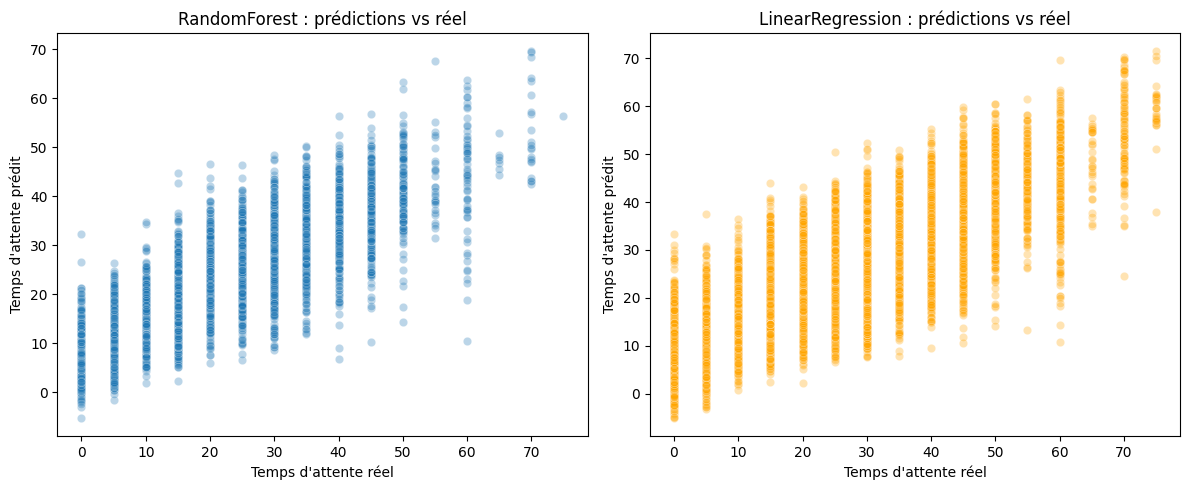

In [151]:

import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x=y_val, y=val_pred, alpha=0.3)
plt.xlabel("Temps d'attente réel")
plt.ylabel("Temps d'attente prédit")
plt.title("RandomForest : prédictions vs réel")

plt.subplot(1,2,2)
sns.scatterplot(x=y_train, y=train_pred, alpha=0.3, color='orange')
plt.xlabel("Temps d'attente réel")
plt.ylabel("Temps d'attente prédit")
plt.title("LinearRegression : prédictions vs réel")
plt.tight_layout()
plt.show()